# Performing Scenario Discovery in Python

The purpose of example is to demonstrate how one can do scenario discovery in python. I will demonstrate how we can perform both PRIM in an interactive way, as well as briefly show how to use CART, which is also available in the exploratory modeling workbench. There is ample literature on both CART and PRIM and their relative merits for use in scenario discovery. So I won't be discussing that here in any detail.

In order to demonstrate the use of the exploratory modeling workbench for scenario discovery, I am using a published example. I am using the data used in the original article by Ben Bryant and Rob Lempert where they first introduced 2010. Ben Bryant kindly made this data available and allowed me to share it. The data comes as a csv file. We can import the data easily using pandas. columns 2 up to and including 10 contain the experimental design, while the classification is presented in column 15

This example is a slightly updated version of a blog post on  https://waterprogramming.wordpress.com/2015/08/05/scenario-discovery-in-python/

In [1]:
import pandas as pd

data = pd.DataFrame.from_csv('./data/bryant et al 2010 data.csv', index_col=False)
x = data.ix[:, 2:11]
y = data.ix[:, 15]

The exploratory modeling workbench is built on top of numpy rather than pandas. This is partly a path dependecy issue. The earliest version of prim in the workbench is from 2012, when pandas was still under heavy development. Another problem is that the pandas does not contain explicit information on the datatypes of the columns. The implementation of prim in the exploratory workbench is however datatype aware, in contrast to the scenario discovery toolkit in R. That is, it will handle categorical data differently than continuous data. Internally, prim uses a numpy structured array for x, and a numpy arrea for y. We can easily transform the pandas dataframe to either. 

In [2]:
x = x.to_records()
y = y.values

the exploratory modeling workbench comes with a seperate analysis package. This analysis package contains prim. So let's import prim. The workbench also has its own logging functionality. We can turn this on to get some more insight into prim while it is running.

In [3]:
from ema_workbench.analysis import prim
from ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);

vensim dll not found, vensim functionality not available
/Users/jhkwakkel/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Next, we need to instantiate the prim algorithm. To mimic the original work of Ben Bryant and Rob Lempert, we set the peeling alpha to 0.1. The peeling alpha determines how much data is peeled off in each iteration of the algorithm. The lower the value, the less data is removed in each iteration. The minimium coverage threshold that a box should meet is set to 0.8. Next, we can use the instantiated algorithm to find a first box. 

In [4]:
prim_alg = prim.Prim(x, y, threshold=0.8, peel_alpha=0.1)
box1 = prim_alg.find_box()

[INFO] 882 points remaining, containing 89 cases of interest
[INFO] mean: 1.0, mass: 0.0510204081633, coverage: 0.505617977528, density: 1.0 restricted_dimensions: 6.0


Let's investigate this first box is some detail. A first thing to look at is the trade off between coverage and density. The box has a convenience function for this called `show_tradeoff`. To support working in the ipython notebook, this method returns a matplotlib figure with some additional information than can be used by mpld3. 

In [5]:
import mpld3

box1.show_tradeoff()
mpld3.display()

As you can see, mpdl3 takes a regular matplotlib figure and transforms it into a d3 figure. In this case we use that to add pop up boxes to the tradeoff scatter plot with additional information on each point. We can also inspect each individual point in more detail. So let's look at point 21, just as in the original paper. For this, we can use the `inspect` method. By default this will display two tables, but we can also make a nice graph instead that contains the same information. 

coverage    0.752809
density     0.770115
mass        0.098639
mean        0.770115
res dim     4.000000
Name: 21, dtype: float64

                            box 21                          
                               min         max     qp values
Demand elasticity        -0.422000   -0.202000  1.184930e-16
Biomass backstop price  150.049995  199.600006  3.515113e-11
Total biomass           450.000000  755.799988  4.716969e-06
Cellulosic cost          72.650002  133.699997  1.574133e-01



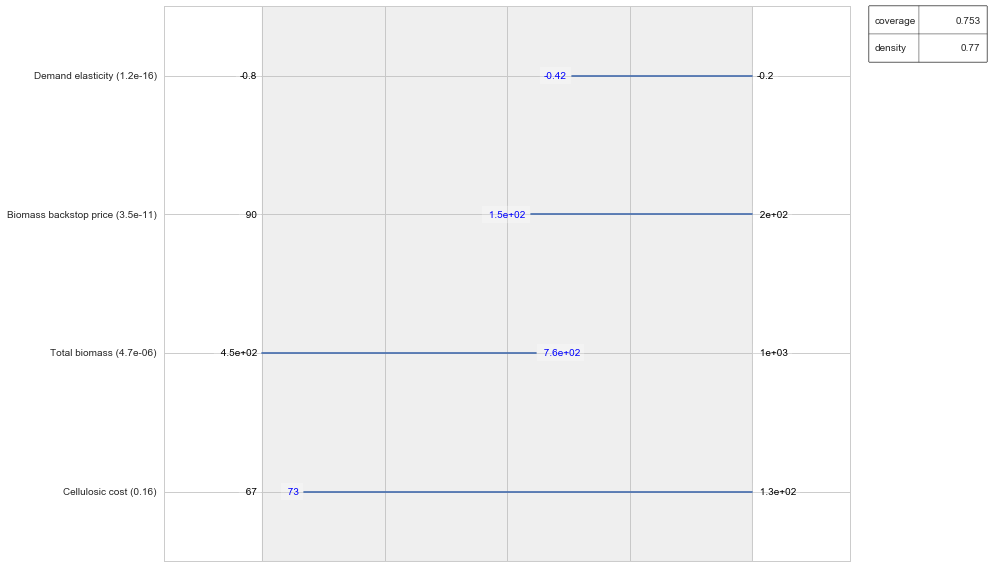

In [6]:
box1.inspect(21)
box1.inspect(21, style='graph')
plt.show()

If one where to do a detailed comparison with the results reported in the original article, one would see small numerical differences. These differences arise out of subtle differences in implementation. The most important difference is that the exploratory modeling workbench uses a custom objective function inside prim which is different from the one used in the scenario discovery toolkit. Other differences have to do with details about the hill climbing optimization that is used in prim, and in particular how ties are handled in selected the next step. The differences between the two implementations are only numerical, and don't affect the overarching conclusions drawn from the analysis. 

Let's select this 21 box, and get a more detailed view of what the box looks like. Following Bryant et al., we can use scatter plots for this. 

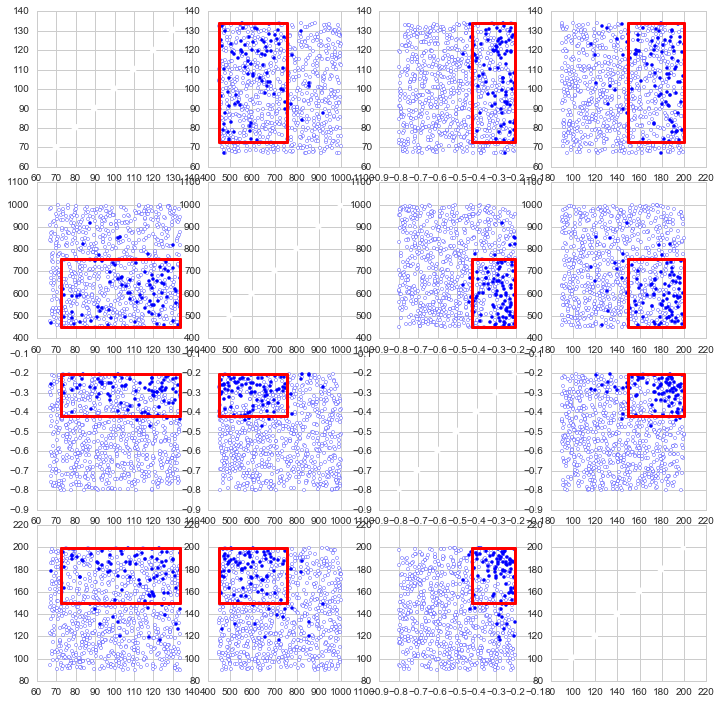

In [7]:
box1.select(21)
fig = box1.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()

Because the last restriction is not significant, we can choose to drop this restriction from the box. 

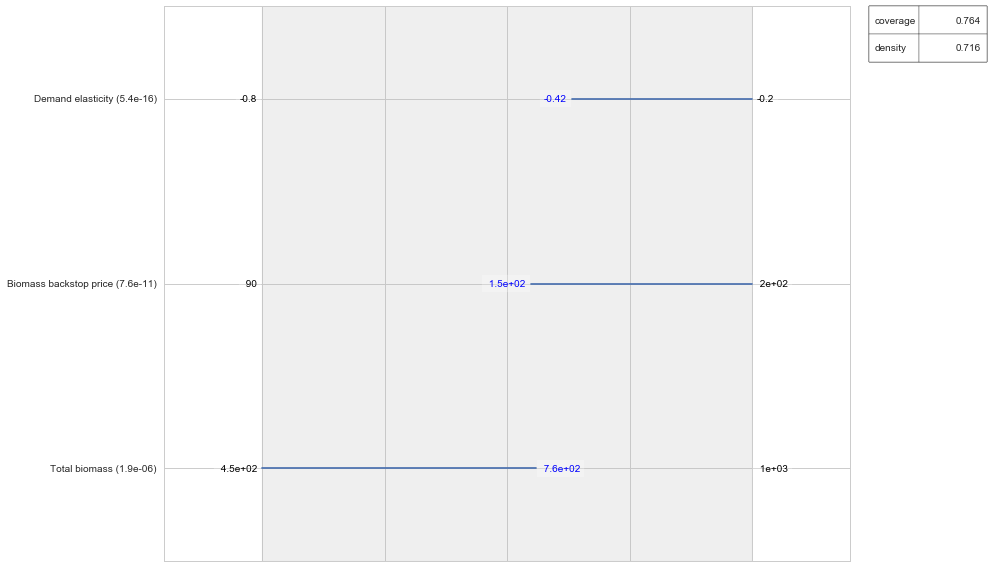

In [8]:
box1.drop_restriction('Cellulosic cost')
box1.inspect(style='graph')
plt.show()

We have now found a first box that explains over 75% of the cases of interest. Let's see if we can find a second box that explains the remainder of the cases.

In [9]:
box2 = prim_alg.find_box()

[INFO] 787 points remaining, containing 21 cases of interest
[INFO] box does not meet threshold criteria, value is 0.354166666667, returning dump box


As we can see, we are unable to find a second box. The best coverage we can achieve is 0.35, which is well below the specified 0.8 threshold. Let's look at the final overal results from interactively fitting PRIM to the data. For this, we can use to convenience functions that transform the stats and boxes to pandas data frames.

In [10]:
print prim_alg.stats_to_dataframe()
print prim_alg.boxes_to_dataframe()

       coverage   density     mass  res_dim
box 1  0.764045  0.715789  0.10771        3
box 2  0.235955  0.026684  0.89229        0
                             box 1              box 2            
                               min         max    min         max
Demand elasticity        -0.422000   -0.202000   -0.8   -0.202000
Biomass backstop price  150.049995  199.600006   90.0  199.600006
Total biomass           450.000000  755.799988  450.0  997.799988


# CART

The way of interacting with CART is quite similar to how we setup the prim analysis. We import cart from the analysis package. We instantiate the algorithm, and next fit CART to the data. This is done via the `build_tree` method.

In [11]:
from ema_workbench.analysis import cart
cart_alg = cart.CART(x,y, 0.05)
cart_alg.build_tree()

Now that we have trained CART on the data, we can investigate its results. Just like PRIM, we can use `stats_to_dataframe` and `boxes_to_dataframe` to get an overview. 

In [12]:
print cart_alg.stats_to_dataframe()
print cart_alg.boxes_to_dataframe()

       coverage   density      mass  res dim
box 1  0.011236  0.021739  0.052154        2
box 2  0.000000  0.000000  0.546485        2
box 3  0.000000  0.000000  0.103175        2
box 4  0.044944  0.090909  0.049887        2
box 5  0.224719  0.434783  0.052154        2
box 6  0.112360  0.227273  0.049887        3
box 7  0.000000  0.000000  0.051020        3
box 8  0.606742  0.642857  0.095238        2
                       box 1                  box 2               box 3  \
                         min         max        min         max     min   
Cellulosic yield        80.0   81.649994  81.649994   99.900002  80.000   
Demand elasticity       -0.8   -0.439000  -0.800000   -0.439000  -0.439   
Biomass backstop price  90.0  199.600006  90.000000  199.600006  90.000   

                                         box 4                box 5  \
                               max         min         max      min   
Cellulosic yield         99.900002   80.000000   99.900002   80.000   
Demand

Alternatively, we might want to look at the classification tree directly. For this, we can use the `show_tree` method. 

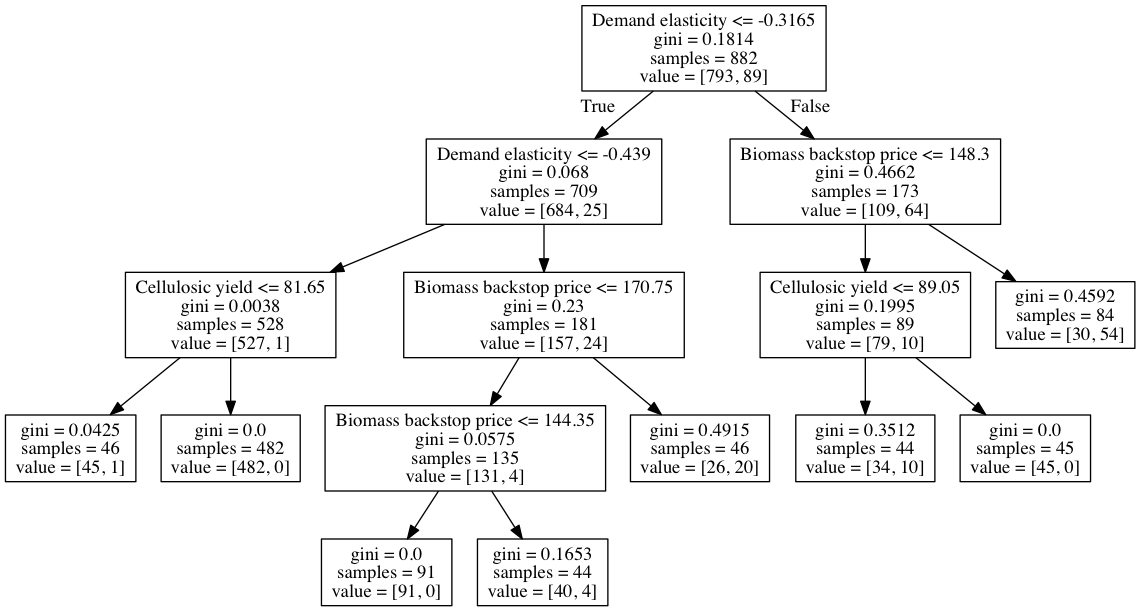

In [13]:
from IPython.display import Image
Image(cart_alg.show_tree()) 